# Heart Disease Prediction

![](./header.jpg)

## Introduction

### Data

This project aims to generate a model to predict the presence of a heart disease. [The UCI heart disease database](https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/) contains 76 attributes, but all published experiments refer to using a subset of 14. The target attribute is an integer valued from 0 (no presence) to 4. However, for sake of simplicity it will be reduced to binary classification, i.e, `0` vs `0 <`. 

*The authors of the databases: Hungarian Institute of Cardiology. Budapest: Andras Janosi, M.D. University Hospital, Zurich, Switzerland: William Steinbrunn, M.D. University Hospital, Basel, Switzerland: Matthias Pfisterer, M.D. V.A. Medical Center, Long Beach and Cleveland Clinic Foundation: Robert Detrano, M.D., Ph.D.*

### Attributes

|  | Description | Variable | Type |
|:---------|:---------------------------------------------------------------------------------------------|:-----------|:--------|
| age | age in years | continuous | `int` |
| sex | 1 = male, 0 = female | categorial | `int` |
| cp | chest pain type: 1: typical angina, 2: atypical angina, 3: non-anginal pain, 4: asymptomatic | categorial | `int` |
| trestbps | resting blood pressure in mm Hg | continuous | `float` |
| chol | serum cholestoral in mg/dl | continuous | `float` |
| fbs | fasting blood sugar > 120 mg/dl: 1 = true, 0 = false | categorial | `int` |
| restecg | 0: normal, 1: having ST-T wave abnormality, 2: left ventricular hypertrophy | categorial | `int` |
| thalach | maximum heart rate achieved | continuous | `float` |
| exang | exercise induced angina (1 = yes; 0 = no) | categorial | `int` |
| oldpeak | ST depression induced by exercise relative to rest | continuous | `float` |
| slope | the slope of the peak exercise ST segment: 1: upsloping, 2: flat, 3: downsloping | categorial | `int` |
| ca | number of major vessels: (0-3) colored by flourosopy | continuous | `int` |
| thal | 3: normal, 6: fixed defect, 7: reversable defect | categorial | `int` |
| target | diagnosis of heart disease: (0 = false, 1 = true | categorial | `int` |


### Flow

[Data fetching](#data-fetching) --> [Wrangling](#wrangling) --> [Data analysis]() --> [Modeling]() --> [evaluation]()

## Python imports

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split as split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import svm 

sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

## Data fetching

In [2]:
link_cleveland = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
link_hungarian = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data'
link_swiss = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data'
link_veniceb = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data'

links = [link_cleveland, link_hungarian, link_swiss, link_veniceb]
names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang',
 'oldpeak', 'slope', 'ca', 'thal', 'target']

df = pd.concat(map(lambda x: pd.read_csv(x, names=names), links))

df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67.0,1.0,4.0,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67.0,1.0,4.0,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37.0,1.0,3.0,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41.0,0.0,2.0,130,204,0,2,172,0,1.4,1,0.0,3.0,0


## Wrangling

### Handling missing values

In [3]:
df.replace('?', np.nan, inplace=True)
df.isnull().sum()

age           0
sex           0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalach      55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
target        0
dtype: int64

In [4]:
df.dropna(axis=0, inplace=True)
df.reset_index(drop = True, inplace = True)

### Correcting data types

In [5]:
df['ca'] = pd.to_numeric(df['ca'], errors='coerce')
df['thal'] = pd.to_numeric(df['thal'], errors='coerce')
df[['age', 'sex', 'cp', 'fbs', 'restecg', 'exang', 'ca', 'slope', 'thal']] = df[['age', 'sex', 'cp', 'fbs', 'restecg', 'exang', 'ca', 'slope', 'thal']].astype(int)
df[['trestbps', 'chol', 'thalach', 'oldpeak']] = df[['trestbps', 'chol', 'thalach', 'oldpeak']].astype(float)
df['target'].replace(to_replace=[1, 2, 3, 4], value=1, inplace=True)

## Exploritory data analysis

### Target

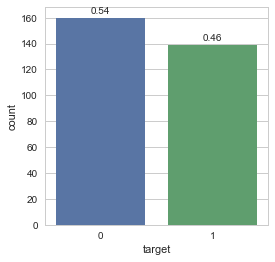

In [6]:
fig_target, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
sns.countplot(x='target', data=df, ax=ax)

for i, p in enumerate(ax.patches):
    count = df['target'].value_counts().values[i]
    ax.text(p.get_x() + p.get_width() /2.,
            p.get_height() + 3,
            '{:1.2f}'.format(count / float(df.shape[0])),
            ha='center')

From the total dataset of 299 instances, **139 (46%) have a heart disease**

### Categorial

#### Categorial plotting function

In [7]:
def plotCategorial(attribute, labels, ax_index):
    sns.countplot(x=attribute, data=df, ax=axes[ax_index][0])
    sns.countplot(x='target', hue=attribute, data=df, ax=axes[ax_index][1])
    avg = df[[attribute, 'target']].groupby([attribute], as_index=False).mean()
    sns.barplot(x=attribute, y='target', hue=attribute, data=avg, ax=axes[ax_index][2])
    
    for t, l in zip(axes[ax_index][1].get_legend().texts, labels):
        t.set_text(l)
    for t, l in zip(axes[ax_index][2].get_legend().texts, labels):
        t.set_text(l)

[None, None, None, None, None, None, None]

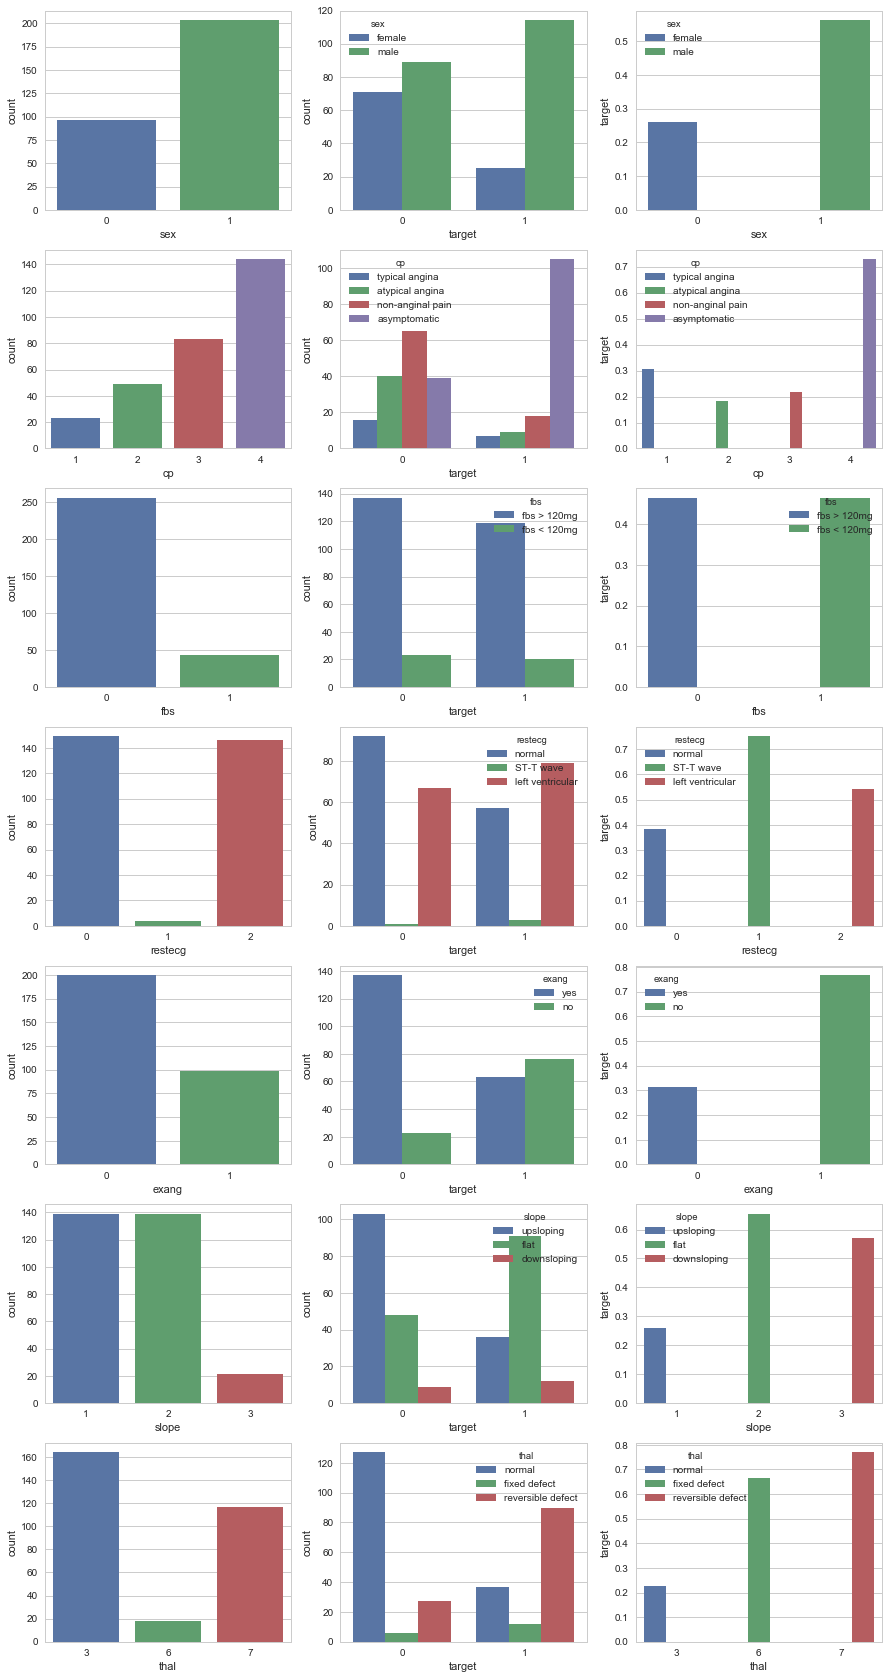

In [8]:
categorial = [('sex', ['female', 'male']), 
              ('cp', ['typical angina', 'atypical angina', 'non-anginal pain', 'asymptomatic']), 
              ('fbs', ['fbs > 120mg', 'fbs < 120mg']), 
              ('restecg', ['normal', 'ST-T wave', 'left ventricular']), 
              ('exang', ['yes', 'no']), 
              ('slope', ['upsloping', 'flat', 'downsloping']), 
              ('thal', ['normal', 'fixed defect', 'reversible defect'])]

fig_categorial, axes = plt.subplots(nrows=len(categorial), ncols=3, figsize=(15, 30))
[plotCategorial(x[0], x[1], i) for i, x in enumerate(categorial)] 

#### Observations
* `sex` has a strong influence on the target variable, where men have a higher frequency of heart disease patiënts
* Respondents with the `typical` or `asymptomatic` chest pain type, seem to have the highest probability of getting a heart disease
* A fasting blood sugar (`fbs`) level of higher or lower than 120 mg/dl is not a good predictor of the target
* From the `restecg` (Resting electrocardiography results), a `normal` seems to have the highest impact on the target
* The presence of `exang` (exercise induced angina) has a relative strong impact on the target
* There is a high decrease in the probability of having a heart disease where respondents have an `upsloping` peak excercise slope
* `thal` might be a good predictor of the target variable

### Continuous

In [9]:
def plotContinuous(attribute, xlabel, ax_index):
    sns.distplot(df[[attribute]], ax=axes[ax_index][0])
    axes[ax_index][0].set(xlabel=xlabel, ylabel='density')
    sns.violinplot(x='target', y=attribute, data=df, ax=axes[ax_index][1])

/usr/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/usr/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/usr/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/usr/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/usr/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: T

[None, None, None, None, None]

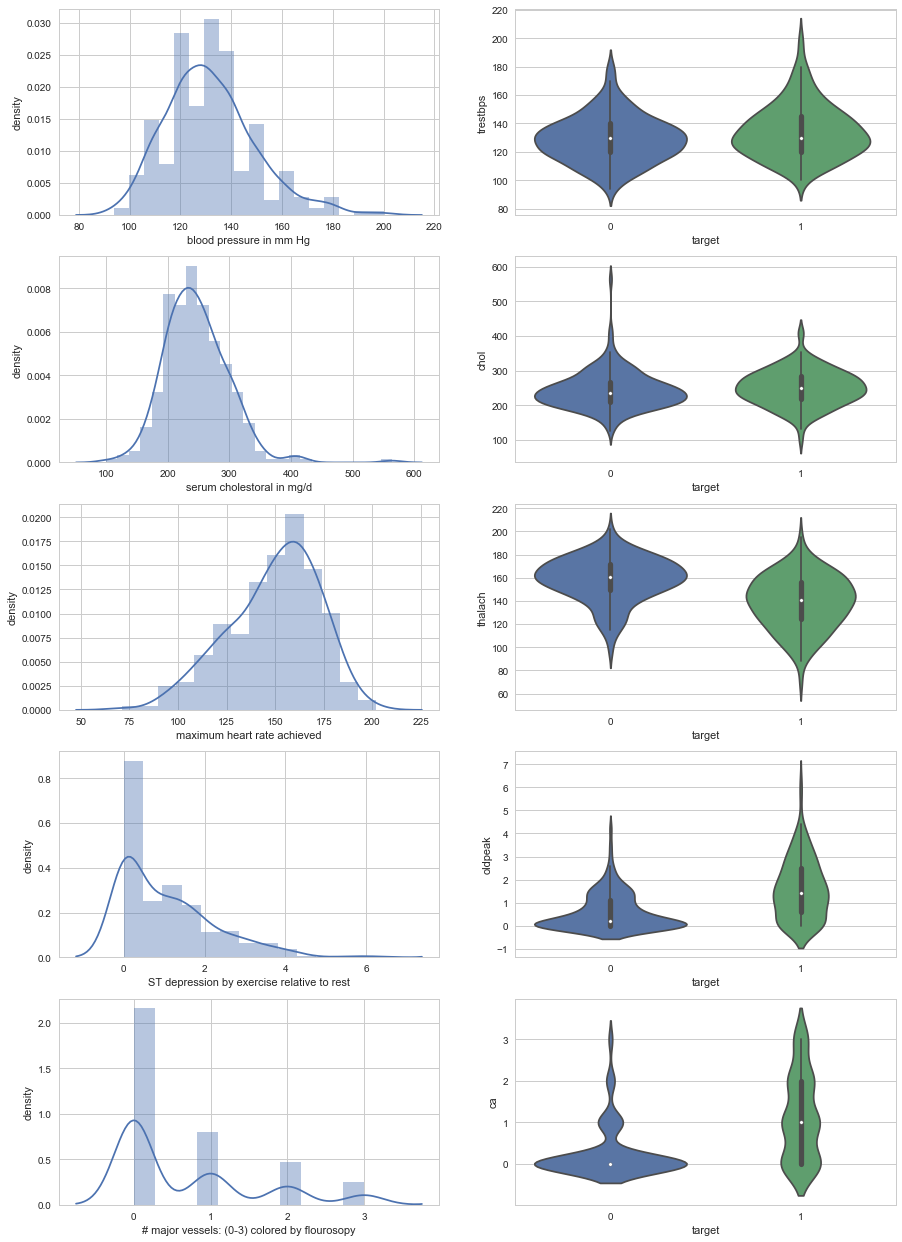

In [10]:
continuous = [('trestbps', 'blood pressure in mm Hg'), 
              ('chol', 'serum cholestoral in mg/d'), 
              ('thalach', 'maximum heart rate achieved'), 
              ('oldpeak', 'ST depression by exercise relative to rest'), 
              ('ca', '# major vessels: (0-3) colored by flourosopy')]
fig_continuous, axes = plt.subplots(nrows=len(continuous), ncols=2, figsize=(15, 22))
[plotContinuous(x[0], x[1], i) for i, x in enumerate(continuous)] 

#### Observations
* `trestbps`, `chol` and `thalach` have a roughly symmetric and unimodal distribution without outliers (impact on target seems weak).
* The most obvious impacts on the target come from `oldpeak` and `ca`, where the amount of major vessels from the `ca` variable has a strong impact on the target variable.

#### Age

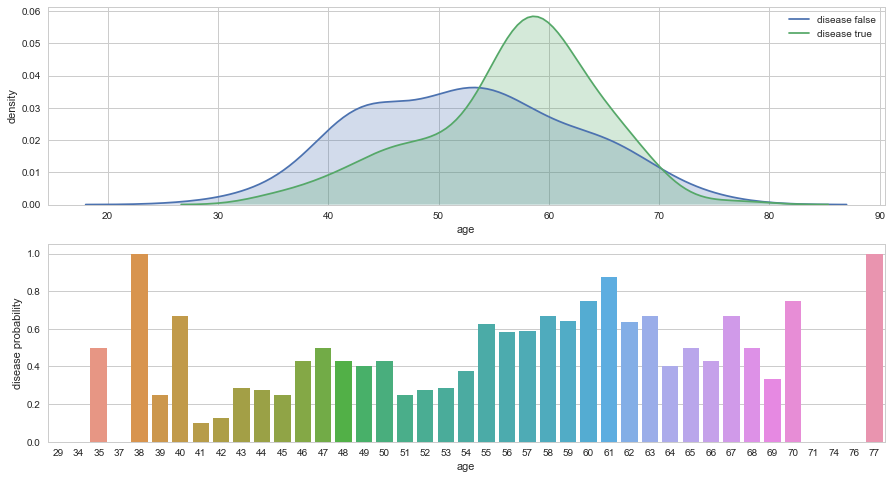

<Figure size 216x216 with 0 Axes>

In [11]:
fig_age, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
facet_grid = sns.FacetGrid(df, hue='target')
facet_grid.map(sns.kdeplot, "age", shade=True, ax=axes[0])
legend_labels = ['disease false', 'disease true']
for t, l in zip(axes[0].get_legend().texts, legend_labels):
    t.set_text(l)
    axes[0].set(xlabel='age', ylabel='density')

avg = df[["age", "target"]].groupby(['age'], as_index=False).mean()
sns.barplot(x='age', y='target', data=avg, ax=axes[1])
axes[1].set(xlabel='age', ylabel='disease probability')

plt.clf()

#### Observations
* `age` has a symmetric and unimodal distribution, where for both target outcomes, the data seems to be centered around 40 to 70 years old
* Respondents with a heart disease peak between 50 and 70 years, with the highest density

## Finalize data for modeling

### Dummy variables

In [12]:
cp_dummy = pd.get_dummies(df['cp'])
cp_dummy.rename(columns={1: 'cp_typical_angina', 2: 'cp_atypical_angina',
                         3: 'cp_non_angina', 4: 'cp_asymptomatic_angina'},
                inplace=True)
restecg_dummy = pd.get_dummies(df['restecg'])
restecg_dummy.rename(columns={0: 'restecg_normal', 1: 'restecg_wave_abnorm',
                              2: 'restecg_ventricular_ht'}, inplace=True)
slope_dummy = pd.get_dummies(df['slope'])
slope_dummy.rename(columns={1: 'slope_upsloping', 2: 'slope_flat',
                            3: 'slope_downsloping'}, inplace=True)
thal_dummy = pd.get_dummies(df['thal'])
thal_dummy.rename(columns={3: 'thal_normal', 6: 'thal_fixed_defect',
                           7: 'thal_reversible_defect'}, inplace=True)
df = pd.concat([df, cp_dummy, restecg_dummy, slope_dummy, thal_dummy], axis=1)
df.drop(['cp', 'restecg', 'slope', 'thal'], axis=1, inplace=True)

### Separate target

In [13]:
df_X = df.drop('target', axis=1)
df_y = df['target']

### Feature selection
Recursive Feature Elimination (RFE) is used to uncover the best or worst performing features. The goal of RFE is to select features by recursively considering smaller and smaller sets of features.

In [14]:
rfe = RFE(LogisticRegression())
rfe.fit(df_X.values, df_y.values)
selected_features = []

for i, col in enumerate(df_X.columns.values):
    if rfe.support_[i]:
        selected_features.append(col)

selected_X = df_X[selected_features]
selected_y = df_y

lm = sm.Logit(selected_y, selected_X)
result = lm.fit()

print result.summary()

Optimization terminated successfully.
         Current function value: 0.343469
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                  299
Model:                          Logit   Df Residuals:                      288
Method:                           MLE   Df Model:                           10
Date:                Sun, 08 Jul 2018   Pseudo R-squ.:                  0.5027
Time:                        07:29:41   Log-Likelihood:                -102.70
converged:                       True   LL-Null:                       -206.51
                                        LLR p-value:                 4.122e-39
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
sex                        1.1754      0.467      2.519      0.012       0.261      

In [15]:
selected_X_train, selected_X_test, selected_y_train, selected_y_test = split(selected_X, selected_y, test_size=0.3, random_state=0)

## Modeling

### Logistic regression

In [16]:
lr = LogisticRegression()
lr.fit(selected_X_train, selected_y_train)

print 'Accuracy: %.3f' % lr.score(selected_X_test, selected_y_test)

Accuracy: 0.844


### Support Vector Machine

#### Tuning

In [17]:
parameters = [{'kernel': ['rbf'], 'gamma': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5],
               'C': [1, 10, 100]},
              {'kernel': ['linear'], 
               'C': [1, 10, 100]}]
grid = GridSearchCV(svm.SVC(decision_function_shape='ovr'), parameters, cv=5)
grid.fit(selected_X_train, selected_y_train)
grid_means = grid.cv_results_['mean_test_score']
grid_stds = grid.cv_results_['std_test_score']

for mean, std, params in zip(grid_means, grid_stds, grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

0.545 (+/-0.009) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.0001}
0.545 (+/-0.009) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.001}
0.837 (+/-0.105) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.01}
0.809 (+/-0.095) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.1}
0.794 (+/-0.064) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.2}
0.789 (+/-0.036) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.5}
0.545 (+/-0.009) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.0001}
0.837 (+/-0.105) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.001}
0.828 (+/-0.082) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.01}
0.799 (+/-0.074) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.1}
0.780 (+/-0.089) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.2}
0.775 (+/-0.080) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.5}
0.837 (+/-0.105) for {'kernel': 'rbf', 'C': 100, 'gamma': 0.0001}
0.828 (+/-0.082) for {'kernel': 'rbf', 'C': 100, 'gamma': 0.001}
0.813 (+/-0.047) for {'kernel': 'rbf', 'C': 100, 'gamma': 0.01}
0.789 (+/-0.110) for {'kernel': 'rbf', 'C': 100, 'gamma

In [18]:
svm_linear = svm.SVC(kernel='linear', C=10)
svm_linear.fit(selected_X_train, selected_y_train)

print 'Accuracy: %.3f' % svm_linear.score(selected_X_test, selected_y_test)

Accuracy: 0.822


### Cross validation

In [19]:
kfold = model_selection.KFold(n_splits=10, random_state=7)
models = [('Linear regression', lr), 
          ('Support vector machine', svm_linear)]

for model in models:
    results = model_selection.cross_val_score(model[1], 
                                              selected_X_train, 
                                              selected_y_train, 
                                              cv=kfold, 
                                              scoring='accuracy')
    print 'Cross validated', model[0], 'Accuracy: %.3f' % results.mean()

Cross validated Linear regression Accuracy: 0.856
Cross validated Support vector machine Accuracy: 0.842


Both models genaralize well when cross validated with 10 splits